<a href="https://colab.research.google.com/github/swsewon3-ship-it/python-for-public-policy_2025-Fall/blob/main/Intro_Text_Analysis_TFIDF_LDA_Inaugurals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Intro to Text Analysis in Python: FreqDist → TF–IDF → Topic Modeling (U.S. Inaugural Addresses)

**Course**: Intro to Text Analysis for Public Policy  
**Format**: Live coding (~2.5 hours) + 60‑min student-driven scavenger hunt  
**Dataset**: U.S. Presidential Inaugural Addresses (via NLTK)

### Learning Outcomes
- Load and lightly clean a real-world corpus.
- Contrast **raw frequency (FreqDist)** vs **TF–IDF** to understand term salience.
- Use **topic modeling (LDA, scikit‑learn)** to uncover corpus‑level themes.
- Compare and interpret outputs to make policy‑relevant claims.


## 🔍 Comparing TF–IDF vs Topic Modeling in Policy Contexts

| Policy Context | What TF–IDF Reveals | What Topic Modeling Reveals | Example Insight |
|----------------|--------------------|-----------------------------|-----------------|
| 🏛 **Legislative & Political Communication** | Distinctive vocabulary by legislator or party (e.g., what makes one member’s rhetoric unique) | Shared themes or issue clusters across speeches (e.g., “healthcare,” “security,” “immigration”) | TF–IDF shows that one senator emphasizes “opioids” while another uses “cybersecurity”; LDA groups all health-related terms into a “public health” topic. |
| 🌐 **Diplomatic & Multilateral Statements** | Country-specific framing of an issue (what each nation stresses) | Global discourse patterns and alliances (how nations group around themes) | TF–IDF highlights Fiji’s use of “loss and damage” vs. the U.S.’s “innovation”; LDA identifies a broader “climate adaptation” topic uniting small island states. |
| 🕊 **NGO & Think-Tank Reports** | Organization-specific keywords that signal focus or mandate | Latent themes that span organizations (e.g., “education policy,” “macroeconomic reform”) | TF–IDF shows UNICEF’s “child rights” language; LDA uncovers cross-agency topics like “financing for development.” |
| 📰 **Media Coverage of Global Policy** | Outlet-specific framing and language choices | Dominant topics in media discourse across sources or time | TF–IDF shows Fox News emphasizes “energy independence,” The Guardian “climate justice”; LDA extracts topics like “energy transition,” “policy negotiations.” |
| ⚖️ **Comparative Policy Texts / Legislation** | Unique legal or regulatory phrasing in each country | Shared or evolving legal concepts across multiple texts | TF–IDF finds Germany stresses “Energiewende”; LDA surfaces a “renewable energy transition” topic appearing in multiple EU laws. |
| 💬 **Public Consultation & Citizen Feedback** | Stakeholder-specific concerns or jargon (e.g., NGOs vs. corporations) | Major themes emerging from thousands of comments | TF–IDF identifies NGOs’ use of “pollution control” vs. industry’s “innovation cost”; LDA clusters all responses into “economic impact,” “environmental justice,” etc. |
| 🧭 **Speeches & Strategic Messaging Over Time** | New or distinctive terms introduced in a given year or presidency | Long-term thematic evolution or cycles in national rhetoric | TF–IDF shows “pandemic” spikes in 2020; LDA reveals enduring topics like “foreign policy,” “domestic economy,” “national security.” |

---

### 🧠 Summary

| Technique | Best For | Analytical Focus |
|------------|-----------|------------------|
| **TF–IDF** | Comparing documents or actors | *“What makes this text distinct?”* |
| **Topic Modeling (LDA)** | Discovering cross-document themes | *“What themes recur across the corpus?”* |

> ✅ Together, they bridge **micro-level distinctiveness** (TF–IDF) and **macro-level patterns** (LDA) — enabling richer analysis of language in policy and diplomacy.



## 1) Environment Setup (Colab‑friendly)
Run this once in Colab to install/upgrade packages and download NLTK data.


In [62]:

# In a fresh runtime (Runtime → Restart runtime), run:
  #NumPy = statistical analysis tool, scipy도 통계, scikit-learn 은 TF-idf 위해 꼭 필요

!pip -q install "numpy==2.0.2" "scipy==1.14.1" "scikit-learn>=1.4"
!pip install nltk==3.9.2

import numpy, scipy, sklearn
print("NumPy:", numpy.__version__)     # → 2.0.2
print("SciPy:", scipy.__version__)     # → 1.14.x
print("sklearn:", sklearn.__version__) # ≥ 1.4


import nltk
nltk.download('inaugural')  #'inaugural'가 corpus 임
nltk.download('stopwords') #a, the 같은 반복어구 클린해주는 패키지
nltk.download('punkt')  #sentence를 단어 청크로 만드는 패키지
# Some environments expect punkt_tab as well:
nltk.download('punkt_tab')

print("✅ Setup complete.")


NumPy: 2.0.2
SciPy: 1.14.1
sklearn: 1.6.1
✅ Setup complete.


[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



## 2) Imports
We use: `nltk` for data & preprocessing, `scikit-learn` for TF–IDF and LDA, `matplotlib/pandas` for exploration.


In [87]:

import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   #차트

from nltk.corpus import inaugural, stopwords
from nltk import word_tokenize, FreqDist  #frequency distribution

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer #TF-idf
from sklearn.metrics.pairwise import cosine_similarity  #단어가 사용되는 맥락도 파악해줌 (단어간의 관계)
from sklearn.decomposition import PCA, LatentDirichletAllocation


# Display all rows and columns (adjust numbers as needed)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Show full text in each cell (no truncation)
pd.set_option('display.max_colwidth', None)

# Expand the display width so wide tables don't wrap
pd.set_option('display.width', 0)

print("✅ Pandas display options set for full view.")

print("✅ Imports loaded.")


✅ Pandas display options set for full view.
✅ Imports loaded.



## 3) Load the U.S. Presidential Inaugural Addresses
We’ll load speeches from NLTK’s `inaugural` corpus. Each document is a speech like `1789-Washington.txt`.


In [88]:

fileids = inaugural.fileids()   #파일이름을 보여주라
print(fileids)

['1789-Washington.txt', '1793-Washington.txt', '1797-Adams.txt', '1801-Jefferson.txt', '1805-Jefferson.txt', '1809-Madison.txt', '1813-Madison.txt', '1817-Monroe.txt', '1821-Monroe.txt', '1825-Adams.txt', '1829-Jackson.txt', '1833-Jackson.txt', '1837-VanBuren.txt', '1841-Harrison.txt', '1845-Polk.txt', '1849-Taylor.txt', '1853-Pierce.txt', '1857-Buchanan.txt', '1861-Lincoln.txt', '1865-Lincoln.txt', '1869-Grant.txt', '1873-Grant.txt', '1877-Hayes.txt', '1881-Garfield.txt', '1885-Cleveland.txt', '1889-Harrison.txt', '1893-Cleveland.txt', '1897-McKinley.txt', '1901-McKinley.txt', '1905-Roosevelt.txt', '1909-Taft.txt', '1913-Wilson.txt', '1917-Wilson.txt', '1921-Harding.txt', '1925-Coolidge.txt', '1929-Hoover.txt', '1933-Roosevelt.txt', '1937-Roosevelt.txt', '1941-Roosevelt.txt', '1945-Roosevelt.txt', '1949-Truman.txt', '1953-Eisenhower.txt', '1957-Eisenhower.txt', '1961-Kennedy.txt', '1965-Johnson.txt', '1969-Nixon.txt', '1973-Nixon.txt', '1977-Carter.txt', '1981-Reagan.txt', '1985-Reaga

In [89]:
records = []
for fid in fileids:
    raw = inaugural.raw(fid) #The .raw() method returns the entire text of one file as a single string — no tokenization, no cleaning, just raw text
    year, president = fid.replace('.txt', '').split('-')[0], fid.replace('.txt', '').split('-')[1] #extracts the year and president’s name from each file’s name in the NLTK inaugural corpus
    records.append({'fileid': fid, 'year': int(year), 'president': president, 'text': raw})
    #마지막줄은 열을 생성하는 것이라고 생각하면돼

df = pd.DataFrame(records).sort_values('year').reset_index(drop=True)
df.head(3)


fileid  year   president  \
0  1789-Washington.txt  1789  Washington   
1  1793-Washington.txt  1793  Washington   
2       1797-Adams.txt  1797       Adams   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               


## 4) Light Preprocessing
Simple, transparent steps:
- lowercase → tokenize → keep alphabetic tokens (len ≥ 3) → remove stopwords  
We also add a small custom stoplist of political boilerplate words.


In [90]:

EN_STOP = set(stopwords.words('english'))
print("English stopwords:", EN_STOP)
CUSTOM_STOP = {
    # corpus artifacts / very generic political words (tweak in class)
    'applause', 'cheers', 'government', 'nation', 'people', 'states', 'united', 'american', 'america'
}
STOPWORDS = EN_STOP.union(CUSTOM_STOP)

def simple_clean_tokens(text):
    """
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens of length >= 3
    4) Remove stopwords
    """
    text = text.lower()
    tokens = word_tokenize(text)
    clean = [tok for tok in tokens if tok.isalpha() and len(tok) >= 3 and tok not in STOPWORDS]
    #토큰은 tokens에 잇는 즉 우리의 텍스트파일에 있는것이어야하고, 알파벳이어야하고, 3알파벳이상이어야하고, 스탑워드가 아니어얀다
    return clean
    #tokenize = 분석의 단위를 결정하는 것, word level 이나 sentence leve로 할 수 있음

df['tokens'] = df['text'].apply(simple_clean_tokens)
df['text_clean'] = df['tokens'].apply(lambda toks: " ".join(toks))
print("Sample tokens:", df.loc[0, 'tokens'][:25])
df[['fileid','year','president','text','text_clean']].head(3)



English stopwords: {'just', 'does', "we've", 'most', 'them', 'which', 'be', "needn't", "that'll", "mustn't", 'own', 'hadn', 'same', 'ourselves', 'any', 'been', 'how', 'doesn', 'do', "won't", "it'll", 'up', 'aren', 'his', 'down', 'having', "she's", 'did', 'there', 'on', 'very', 'out', 'yourselves', "it's", 'wasn', 'than', 'yourself', 'd', 'is', 'themselves', "isn't", 'by', 'more', "they'll", "she'd", 'above', 'to', 'too', "weren't", 'few', 'couldn', 'your', "they'd", 'other', 'while', 'of', 'i', "should've", "he'd", 'or', "you've", 'myself', 'herself', 'him', 'if', 'over', 've', "i'll", 'the', 'had', 'will', 'being', 'those', "we'll", 'these', 'against', 'what', 'a', 'was', 'won', 'in', "we're", 'nor', 'hers', 'then', 'we', "you're", 'until', 'll', 'at', 'an', 'our', "didn't", 'were', "we'd", "he'll", 'with', 'haven', 'didn', 'for', 'and', 'they', "hadn't", 'but', "shan't", 'it', 'as', 'mustn', 'during', 'here', 'can', 'my', 'after', "mightn't", 'before', 'from', "it'd", "she'll", 'ma',

fileid  year   president  \
0  1789-Washington.txt  1789  Washington   
1  1793-Washington.txt  1793  Washington   
2       1797-Adams.txt  1797       Adams   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               


## 5) Quick Exploration
A glance at token counts and frequent words gives intuition before modeling.


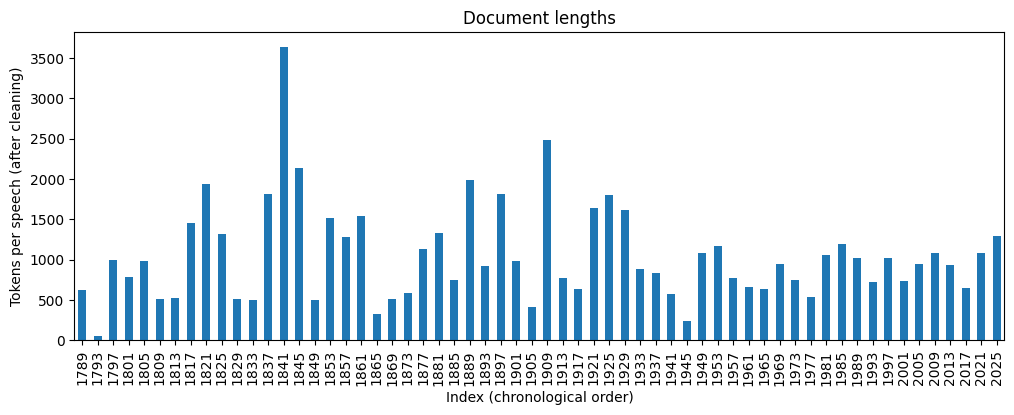

term  count
0           must    375
1           upon    371
2          great    356
3          world    353
4            may    343
5        country    336
6          shall    316
7          every    309
8            one    274
9          peace    259
10           new    256
11         power    246
12        public    229
13          time    224
14      citizens    217
15         would    215
16  constitution    210
17       nations    199
18         union    190
19       freedom    188

In [91]:

# Document lengths
df['n_tokens'] = df['tokens'].apply(len)
ax = df.plot(x='year', y='n_tokens', kind='bar', figsize=(12,4), legend=False)
ax.set_ylabel("Tokens per speech (after cleaning)")
ax.set_xlabel("Index (chronological order)")
ax.set_title("Document lengths")
plt.show()

# Global top terms (sanity check)
all_terms = [t for toks in df['tokens'] for t in toks]
top20 = Counter(all_terms).most_common(20)
pd.DataFrame(top20, columns=['term','count'])


English stopwords: {'just', 'does', "we've", 'most', 'them', 'which', 'be', "needn't", "that'll", "mustn't", 'own', 'hadn', 'same', 'ourselves', 'any', 'been', 'how', 'doesn', 'do', "won't", "it'll", 'up', 'aren', 'his', 'down', 'having', "she's", 'did', 'there', 'on', 'very', 'out', 'yourselves', "it's", 'wasn', 'than', 'yourself', 'd', 'is', 'themselves', "isn't", 'by', 'more', "they'll", "she'd", 'above', 'to', 'too', "weren't", 'few', 'couldn', 'your', "they'd", 'other', 'while', 'of', 'i', "should've", "he'd", 'or', "you've", 'myself', 'herself', 'him', 'if', 'over', 've', "i'll", 'the', 'had', 'will', 'being', 'those', "we'll", 'these', 'against', 'what', 'a', 'was', 'won', 'in', "we're", 'nor', 'hers', 'then', 'we', "you're", 'until', 'll', 'at', 'an', 'our', "didn't", 'were', "we'd", "he'll", 'with', 'haven', 'didn', 'for', 'and', 'they', "hadn't", 'but', "shan't", 'it', 'as', 'mustn', 'during', 'here', 'can', 'my', 'after', "mightn't", 'before', 'from', "it'd", "she'll", 'ma',

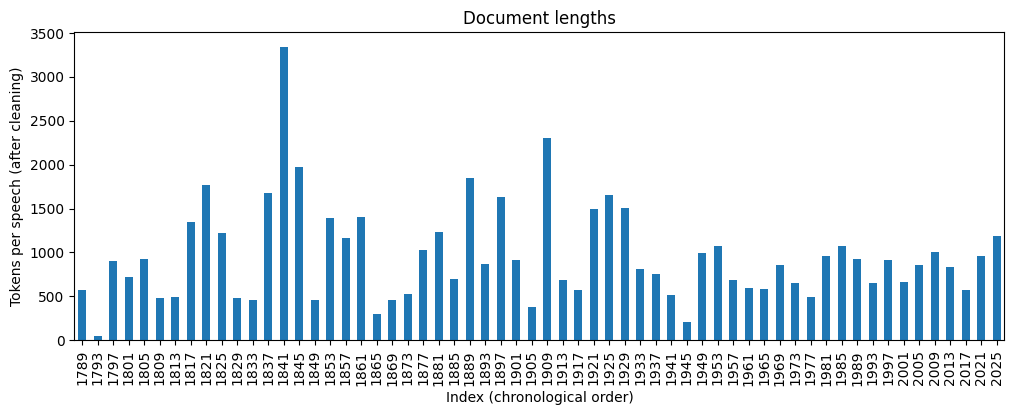

term  count
0          world    353
1          peace    259
2            new    256
3          power    246
4         public    229
5       citizens    217
6   constitution    210
7          union    190
8        freedom    188
9           free    187
10           war    182
11      national    161
12       justice    146
13        spirit    144
14          life    143
15        rights    139
16           law    131
17      congress    130
18          laws    130
19         right    127
20          work    125
21          best    123
22          hope    122
23       liberty    122
24          duty    121
25     interests    115
26           god    113
27        fellow    112
28         state    112
29     political    110

In [93]:

EN_STOP = set(stopwords.words('english'))
print("English stopwords:", EN_STOP)
CUSTOM_STOP = {
    # corpus artifacts / very generic political words (tweak in class)
    'applause', 'may', 'would', 'every', 'shall', 'did', 'one', 'nations' 'every', 'must', 'let', 'made',
    'should', 'cheers', 'government', 'nation', 'people', 'states', 'united', 'never', 'without', 'with', 'much', 'many',
    'american', 'america', 'nations', 'make', 'time', 'times', 'years', 'year', 'upon', 'country', 'men', 'today', 'american',
    'since', 'americans', 'great', "briefly", 'good', 'well', 'know'
}
STOPWORDS = EN_STOP.union(CUSTOM_STOP)

def simple_clean_tokens(text):
    """
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens of length >= 3
    4) Remove stopwords
    """
    text = text.lower()
    tokens = word_tokenize(text)
    clean = [tok for tok in tokens if tok.isalpha() and len(tok) >= 3 and tok not in STOPWORDS]
    #토큰은 tokens에 잇는 즉 우리의 텍스트파일에 있는것이어야하고, 알파벳이어야하고, 3알파벳이상이어야하고, 스탑워드가 아니어얀다
    return clean
    #tokenize = 분석의 단위를 결정하는 것, word level 이나 sentence leve로 할 수 있음

df['tokens'] = df['text'].apply(simple_clean_tokens)
df['text_clean'] = df['tokens'].apply(lambda toks: " ".join(toks))
print("Sample tokens:", df.loc[0, 'tokens'][:25])
df[['fileid','year','president','text','text_clean']].head(3)


# Document lengths
df['n_tokens'] = df['tokens'].apply(len)
ax = df.plot(x='year', y='n_tokens', kind='bar', figsize=(12,4), legend=False)
ax.set_ylabel("Tokens per speech (after cleaning)")
ax.set_xlabel("Index (chronological order)")
ax.set_title("Document lengths")
plt.show()

# Global top terms (sanity check)
all_terms = [t for toks in df['tokens'] for t in toks]
top20 = Counter(all_terms).most_common(30)
pd.DataFrame(top20, columns=['term','count'])




## 5.5) Keyword Frequency (NLTK `FreqDist`) → Why TF–IDF?
`FreqDist` counts words across the **entire corpus**. High counts may reflect words that are common everywhere—not necessarily distinctive.

**Idea:** Use FreqDist to see the *loudest* words, then use TF–IDF to see the *most distinctive per document*.


Top 20 most frequent words across all speeches:

world           353
peace           259
new             256
power           246
public          229
citizens        217
constitution    210
union           190
freedom         188
free            187
war             182
national        161
justice         146
spirit          144
life            143
rights          139
law             131
congress        130
laws            130
right           127


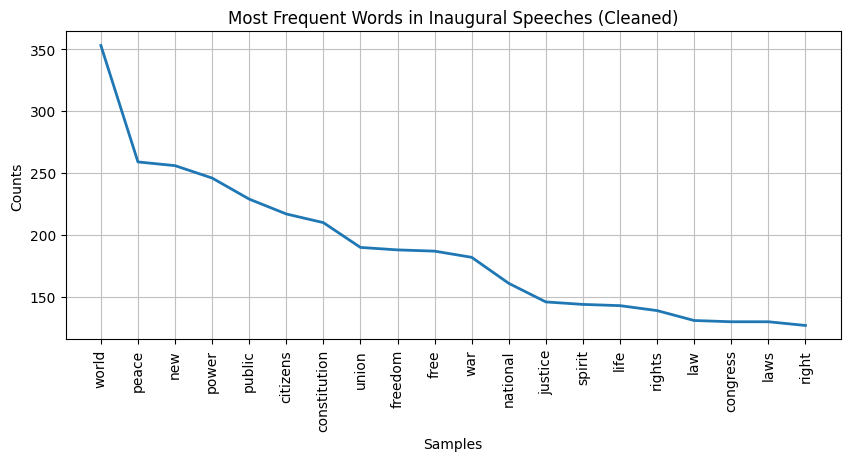

In [94]:

all_tokens = [t for toks in df['tokens'] for t in toks]
fdist = FreqDist(all_tokens)

print("Top 20 most frequent words across all speeches:\n")
for word, freq in fdist.most_common(20):
    print(f"{word:15s} {freq}")

# Visualize (optional)
plt.figure(figsize=(10,4))
fdist.plot(20, cumulative=False)
plt.title("Most Frequent Words in Inaugural Speeches (Cleaned)")
plt.show()



## 6) TF–IDF with scikit‑learn
**TF–IDF** = term frequency × inverse document frequency  
- Highlights terms that are frequent **and** specific to a document.  
- Downweights terms that appear in many documents.


In [95]:

# convert a collection of text documents (your speeches) into a matrix where: Each row = one document (a speech);
# Each column = one term (a word);
# Each cell value = TF–IDF weight of that term in that document
# min_df=2 → ignore words that appear in fewer than 2 documents
tfidf = TfidfVectorizer(min_df=2)

# Feeds your cleaned text (from the text_clean column) into the vectorizer.
# Two steps happen in one command:
# .fit() — learns the vocabulary and IDF (Inverse Document Frequency) weights.
# .transform() — applies the TF–IDF transformation to each document.
# Returns a sparse matrix X_tfidf of shape:

X_tfidf = tfidf.fit_transform(df['text_clean'])

# Retrieves the list of all terms (vocabulary) that the vectorizer kept.
# Converts it into a NumPy array for easy indexing and sorting later.
# You’ll use it when finding the top TF–IDF terms for each speech:

terms = np.array(tfidf.get_feature_names_out())

# ((# of docs, # of unique words), # of unique words)
X_tfidf.shape, len(terms)


((60, 5092), 5092)

60개의 문서, 5092의 unique words 라는 듯임

In [97]:

def top_tfidf_terms_for_doc(doc_idx, top_n=12): #Define a function that returns the top-n TF–IDF terms for a single document (speech).
    row = X_tfidf.getrow(doc_idx).toarray().ravel() #row is a vector of TF–IDF scores for one speech, where each position corresponds to one word in terms
    top_idx = row.argsort()[::-1][:top_n] #top_idx = positions of the most distinctive words in this speech.
    # terms[top_idx] gets the actual word strings for those indices.
    # row[top_idx] gets their corresponding TF–IDF scores.
    # zip(...) pairs each word with its score.
    # list(...) turns that into a list of (word, score) tuples.
    return list(zip(terms[top_idx], row[top_idx]))


# Show a few speeches (early, middle, recent)
# This loop picks three speeches: The first (i = 0), The middle one (len(df)//2), The last one (len(df)-1)
for i in [0, len(df)//2, len(df)-1]:
    print(f"\n=== {df.loc[i, 'year']} - {df.loc[i, 'president']} ===") #Prints a header showing which speech you’re examining
    for term, score in top_tfidf_terms_for_doc(i, top_n=12): #Calls the function to get the top 12 terms for that document
        print(f"{term:15s} {score:.3f}")


=== 1789 - Washington ===
ought           0.117
immutable       0.116
impressions     0.116
providential    0.116
public          0.113
present         0.112
qualifications  0.107
peculiarly      0.101
measures        0.096
deliberations   0.096
pecuniary       0.096
article         0.096

=== 1909 - Taft ===
business        0.219
negro           0.166
tariff          0.162
south           0.140
proper          0.125
feeling         0.121
race            0.121
bill            0.116
employees       0.113
canal           0.113
amendment       0.111
congress        0.110

=== 2025 - Trump ===
thank           0.422
going           0.191
back            0.167
panama          0.151
win             0.114
immediately     0.114
sign            0.112
like            0.103
president       0.098
dream           0.093
bring           0.088
restore         0.088


In [98]:

def top_tfidf_terms_for_doc(doc_idx, top_n=20): #Define a function that returns the top-n TF–IDF terms for a single document (speech).
    row = X_tfidf.getrow(doc_idx).toarray().ravel() #row is a vector of TF–IDF scores for one speech, where each position corresponds to one word in terms
    top_idx = row.argsort()[::-1][:top_n] #top_idx = positions of the most distinctive words in this speech.
    # terms[top_idx] gets the actual word strings for those indices.
    # row[top_idx] gets their corresponding TF–IDF scores.
    # zip(...) pairs each word with its score.
    # list(...) turns that into a list of (word, score) tuples.
    return list(zip(terms[top_idx], row[top_idx]))


# Show a few speeches (early, middle, recent)
# This loop picks three speeches: The first (i = 0), The middle one (len(df)//2), The last one (len(df)-1)
for i in [0, len(df)//2, len(df)-1]:
    print(f"\n=== {df.loc[i, 'year']} - {df.loc[i, 'president']} ===") #Prints a header showing which speech you’re examining
    for term, score in top_tfidf_terms_for_doc(i, top_n=20): #Calls the function to get the top 12 terms for that document
        print(f"{term:15s} {score:.3f}")


=== 1789 - Washington ===
ought           0.117
immutable       0.116
impressions     0.116
providential    0.116
public          0.113
present         0.112
qualifications  0.107
peculiarly      0.101
measures        0.096
deliberations   0.096
pecuniary       0.096
article         0.096
rendered        0.096
retreat         0.091
dare            0.087
expedient       0.087
nature          0.085
hand            0.082
sentiments      0.081
house           0.081

=== 1909 - Taft ===
business        0.219
negro           0.166
tariff          0.162
south           0.140
proper          0.125
feeling         0.121
race            0.121
bill            0.116
employees       0.113
canal           0.113
amendment       0.111
congress        0.110
army            0.107
legislation     0.105
likely          0.102
trade           0.098
passed          0.097
suitable        0.097
federal         0.093
incoming        0.092

=== 2025 - Trump ===
thank           0.422
going           0.191
back  


### TF–IDF Similarity (Cosine)
Find which speeches are lexically similar using cosine similarity on TF–IDF vectors.


예를 들어, 기후변화에 대한 유엔 회원국들의 스피치를 분석하면, 그들의 스텐스를 알 수가 있다는 것이지! ~

In [99]:

sim = cosine_similarity(X_tfidf) #Computes a cosine similarity matrix for all speeches
target = len(df) - 1  # Chooses the most recent speech (the last row in your DataFrame) as the target document.
#베이스라인 비교를 위한 걸 설정하는 것
pairs = [(i, sim[target, i]) for i in range(len(df)) if i != target] #Builds a list of tuples for every other speech, skips the target one
pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)[:5] #Sorts the list of (index, similarity) pairs by similarity score in descending order

print(f"Most similar to {df.loc[target,'year']} - {df.loc[target,'president']}:")
for idx, score in pairs_sorted: #Iterates over the top-5 most similar speeches
    print(f"  {df.loc[idx,'year']} - {df.loc[idx,'president']:12s}  (cosine={score:.3f})")

# Cosine similarity treats each speech as a high-dimensional vector (words as axes).
# The closer the angle between two vectors, the more similar their language use — even if the speeches differ in length.


Most similar to 2025 - Trump:
  2017 - Trump         (cosine=0.337)
  2021 - Biden         (cosine=0.277)
  1989 - Bush          (cosine=0.245)
  1981 - Reagan        (cosine=0.239)
  2009 - Obama         (cosine=0.230)


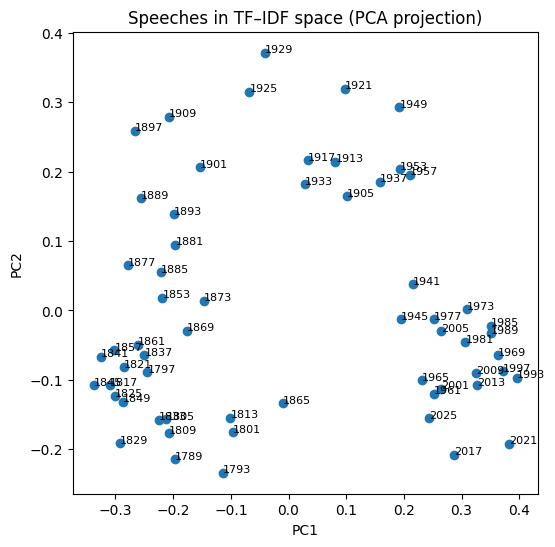

In [73]:

# 2D projection (small corpus → OK to densify)
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_tfidf.toarray())
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(coords[:,0], coords[:,1])
for i, row in df.iterrows():
    ax.annotate(str(row['year']), (coords[i,0], coords[i,1]), fontsize=8)
ax.set_title("Speeches in TF–IDF space (PCA projection)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.show()


🎨 How to interpret the chart
1. Each point = a speech represented by its overall word usage pattern

* Two speeches close together → use similar vocabularies (in terms of TF–IDF weighting).

* Far apart → distinct word usage — different priorities, tone, or historical context.

2. Axes (PC1 and PC2) are abstract — they don’t correspond to literal variables

* PCA components are linear combinations of all TF–IDF features (words).

* You can’t say “the x-axis means optimism vs war,” but you can say:

* “Along PC1, speeches separate based on major vocabulary differences — early vs modern language, perhaps.”

* You can interpret them qualitatively by checking which speeches cluster together.

3. Look for clusters, trends, or outliers

* Clusters of speeches by nearby years → continuity in rhetoric or themes.

* Isolated points → outlier speeches (perhaps unusually short, poetic, or issue-focused).

* You might see a chronological gradient: early 1800s on one side, 2000s on another — showing the evolution of presidential language.

| Concept   | Interpretation                                           |
| --------- | -------------------------------------------------------- |
| Distance  | How different two speeches’ vocabularies are             |
| Clusters  | Shared themes, era, or rhetorical style                  |
| Outliers  | Unique speeches that break linguistic patterns           |
| PC1 / PC2 | Major axes of variation in word use — not literal topics |


In [100]:
df[['year','president']].assign(PC1=coords[:,0], PC2=coords[:,1]).sort_values('PC1').head()


year president       PC1       PC2
14  1845      Polk -0.337197 -0.107406
13  1841  Harrison -0.325385 -0.066658
7   1817    Monroe -0.310102 -0.107828
17  1857  Buchanan -0.301891 -0.057029
9   1825     Adams -0.301400 -0.123348

## 🎨 Visualizing TF–IDF: Word Cloud & Temporal Trend

Now that we’ve mapped speeches in abstract “TF–IDF space,”  
let’s explore two other ways to *see* what TF–IDF tells us.

1. **Word Cloud** – visually emphasizes the distinctive words in one speech.  
   - Larger words = higher TF–IDF scores.  
   - Great for quick, qualitative insight into what stands out.

2. **Temporal Line Chart** – tracks how the importance of a given term changes over time.  
   - Example: does *“freedom”* rise or fall in salience across U.S. history?


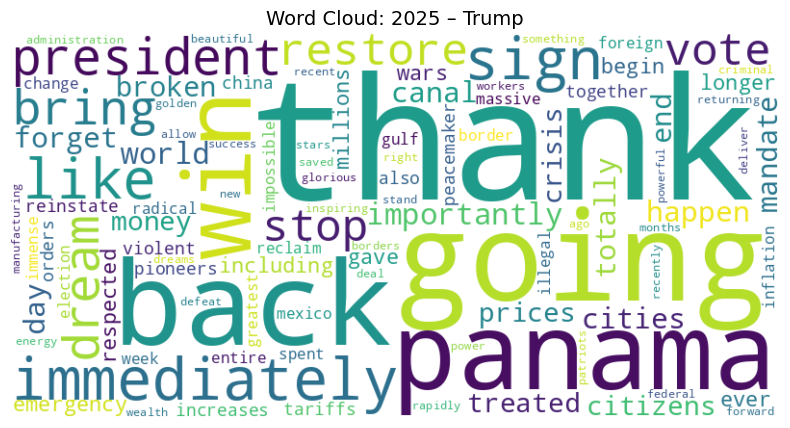

In [101]:
# --- 1) Word Cloud for a Selected Speech ---
from wordcloud import WordCloud

# Pick a speech by index (0=earliest, -1=latest)
doc_idx = len(df) - 1  # last speech by default

# Generate dictionary of top TF–IDF terms
wc_data = dict(top_tfidf_terms_for_doc(doc_idx, top_n=100))

# Create and display the word cloud
wc = WordCloud(width=800, height=400, background_color='white')
wc.generate_from_frequencies(wc_data)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title(f"Word Cloud: {df.loc[doc_idx,'year']} – {df.loc[doc_idx,'president']}", fontsize=14)
plt.show()



단어별로 이게 얼마나 중요한지 다큐멘트별로 비교분석해서 보여주는 기능

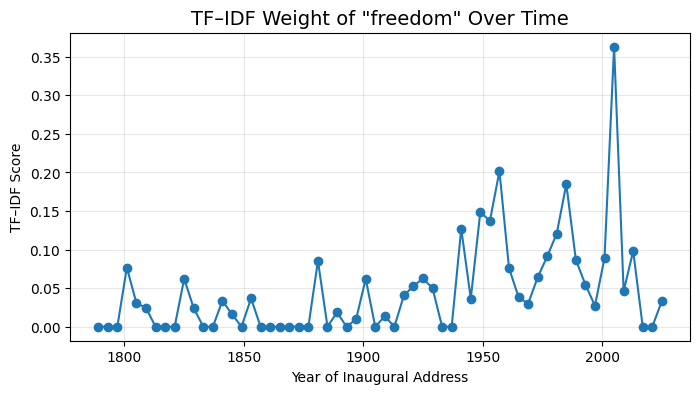

In [102]:
# --- 2) Temporal Line Chart of a Word's TF–IDF Weight ---
# Choose a term to track over time
term = "freedom"  # try swapping to 'war', 'peace', 'america', etc.

if term in terms:
    term_idx = np.where(terms == term)[0][0]
    df[f"tfidf_{term}"] = X_tfidf[:, term_idx].toarray().ravel()

    plt.figure(figsize=(8,4))
    plt.plot(df['year'], df[f"tfidf_{term}"], marker='o', linestyle='-')
    plt.title(f'TF–IDF Weight of "{term}" Over Time', fontsize=14)
    plt.xlabel("Year of Inaugural Address")
    plt.ylabel("TF–IDF Score")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print(f'Term "{term}" not found in vocabulary. Try another word.')

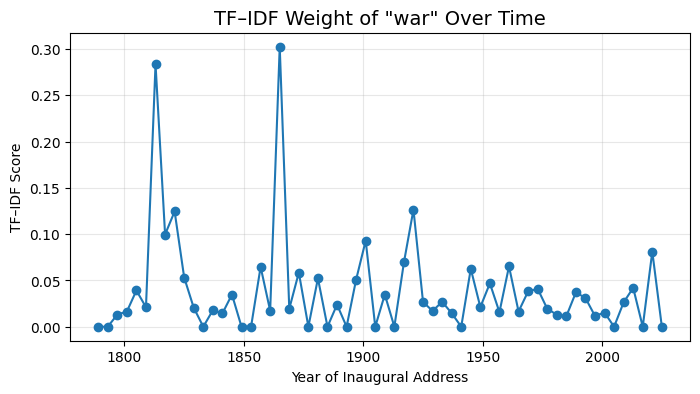

In [103]:
# --- 2) Temporal Line Chart of a Word's TF–IDF Weight ---
# Choose a term to track over time
term = "war"  # try swapping to 'war', 'peace', 'america', etc.

if term in terms:
    term_idx = np.where(terms == term)[0][0]
    df[f"tfidf_{term}"] = X_tfidf[:, term_idx].toarray().ravel()

    plt.figure(figsize=(8,4))
    plt.plot(df['year'], df[f"tfidf_{term}"], marker='o', linestyle='-')
    plt.title(f'TF–IDF Weight of "{term}" Over Time', fontsize=14)
    plt.xlabel("Year of Inaugural Address")
    plt.ylabel("TF–IDF Score")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print(f'Term "{term}" not found in vocabulary. Try another word.')

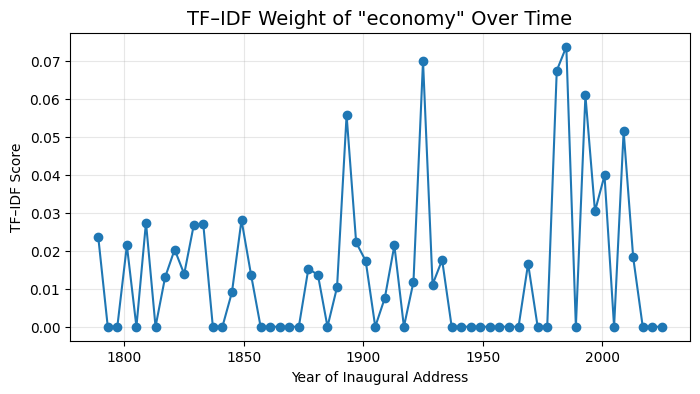

In [104]:
# --- 2) Temporal Line Chart of a Word's TF–IDF Weight ---
# Choose a term to track over time
term = "economy"  # try swapping to 'war', 'peace', 'america', etc.

if term in terms:
    term_idx = np.where(terms == term)[0][0]
    df[f"tfidf_{term}"] = X_tfidf[:, term_idx].toarray().ravel()

    plt.figure(figsize=(8,4))
    plt.plot(df['year'], df[f"tfidf_{term}"], marker='o', linestyle='-')
    plt.title(f'TF–IDF Weight of "{term}" Over Time', fontsize=14)
    plt.xlabel("Year of Inaugural Address")
    plt.ylabel("TF–IDF Score")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print(f'Term "{term}" not found in vocabulary. Try another word.')

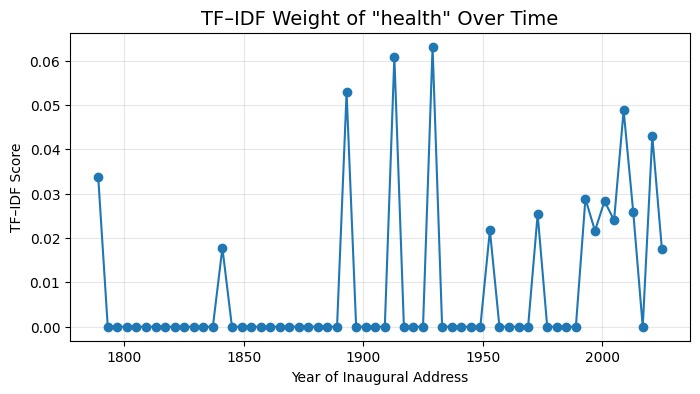

In [105]:
# --- 2) Temporal Line Chart of a Word's TF–IDF Weight ---
# Choose a term to track over time
term = "health"  # try swapping to 'war', 'peace', 'america', etc.

if term in terms:
    term_idx = np.where(terms == term)[0][0]
    df[f"tfidf_{term}"] = X_tfidf[:, term_idx].toarray().ravel()

    plt.figure(figsize=(8,4))
    plt.plot(df['year'], df[f"tfidf_{term}"], marker='o', linestyle='-')
    plt.title(f'TF–IDF Weight of "{term}" Over Time', fontsize=14)
    plt.xlabel("Year of Inaugural Address")
    plt.ylabel("TF–IDF Score")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print(f'Term "{term}" not found in vocabulary. Try another word.')


> ✅ **What TF–IDF tells us**: which words uniquely characterize each speech; which speeches use similar vocabularies.  
> ❌ **What it doesn’t**: explicitly uncover *themes* shared across documents.



## 7) Topic Modeling with scikit‑learn’s LDA
**Latent Dirichlet Allocation (LDA)** models each document as a mixture of **topics** (word distributions).  
We’ll build a bag‑of‑words matrix, fit an LDA model, inspect topics, and examine per‑speech topic mixtures.


In [106]:
df

fileid  year   president  \
0   1789-Washington.txt  1789  Washington   
1   1793-Washington.txt  1793  Washington   
2        1797-Adams.txt  1797       Adams   
3    1801-Jefferson.txt  1801   Jefferson   
4    1805-Jefferson.txt  1805   Jefferson   
5      1809-Madison.txt  1809     Madison   
6      1813-Madison.txt  1813     Madison   
7       1817-Monroe.txt  1817      Monroe   
8       1821-Monroe.txt  1821      Monroe   
9        1825-Adams.txt  1825       Adams   
10     1829-Jackson.txt  1829     Jackson   
11     1833-Jackson.txt  1833     Jackson   
12    1837-VanBuren.txt  1837    VanBuren   
13    1841-Harrison.txt  1841    Harrison   
14        1845-Polk.txt  1845        Polk   
15      1849-Taylor.txt  1849      Taylor   
16      1853-Pierce.txt  1853      Pierce   
17    1857-Buchanan.txt  1857    Buchanan   
18     1861-Lincoln.txt  1861     Lincoln   
19     1865-Lincoln.txt  1865     Lincoln   
20       1869-Grant.txt  1869       Grant   
21       1873-Grant.txt  1873       Grant   
22       1877-Hayes.txt  1877       Hayes   
23    1881-Garfield.txt  1881    Garfield   
24   1885-Cleveland.txt  1885   Cleveland   
25    1889-Harrison.txt  1889    Harrison   
26   1893-Cleveland.txt  1893   Cleveland   
27    1897-McKinley.txt  1897    McKinley   
28    1901-McKinley.txt  1901    McKinley   
29   1905-Roosevelt.txt  1905   Roosevelt   
30        1909-Taft.txt  1909        Taft   
31      1913-Wilson.txt  1913      Wilson   
32      1917-Wilson.txt  1917      Wilson   
33     1921-Harding.txt  1921     Harding   
34    1925-Coolidge.txt  1925    Coolidge   
35      1929-Hoover.txt  1929      Hoover   
36   1933-Roosevelt.txt  1933   Roosevelt   
37   1937-Roosevelt.txt  1937   Roosevelt   
38   1941-Roosevelt.txt  1941   Roosevelt   
39   1945-Roosevelt.txt  1945   Roosevelt   
40      1949-Truman.txt  1949      Truman   
41  1953-Eisenhower.txt  1953  Eisenhower   
42  1957-Eisenhower.txt  1957  Eisenhower   
43     1961-Kennedy.txt  1961     Kennedy   
44     1965-Johnson.txt  1965     Johnson   
45       1969-Nixon.txt  1969       Nixon   
46       1973-Nixon.txt  1973       Nixon   
47      1977-Carter.txt  1977      Carter   
48      1981-Reagan.txt  1981      Reagan   
49      1985-Reagan.txt  1985      Reagan   
50        1989-Bush.txt  1989        Bush   
51     1993-Clinton.txt  1993     Clinton   
52     1997-Clinton.txt  1997     Clinton   
53        2001-Bush.txt  2001        Bush   
54        2005-Bush.txt  2005        Bush   
55       2009-Obama.txt  2009       Obama   
56       2013-Obama.txt  2013       Obama   
57       2017-Trump.txt  2017       Trump   
58       2021-Biden.txt  2021       Biden   
59       2025-Trump.txt  2025       Trump   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [107]:

# Bag-of-words for LDA
  # CountVectorizer converts each document into a bag-of-words (word counts, not weights).
  # min_df=2 means: ignore words that appear in fewer than 2 speeches (to reduce noise).
  # fit_transform() builds the vocabulary and creates a document-term matrix: Rows = speeches; Columns = unique words; Values = how many times each word appears
  # vocab holds the list of all words (for displaying topic terms later).

cv = CountVectorizer(min_df=2)
X_counts = cv.fit_transform(df['text_clean'])
vocab = np.array(cv.get_feature_names_out())

# Train LDA
  # K is the number of topics you want the model to find.
  # This is not learned automatically — it’s a parameter you choose.
  # Try experimenting with different values:
    # K=5 → broader, more general themes (e.g., “war,” “economy,” “unity”).
    # K=8 → more nuanced topics (e.g., “foreign policy,” “domestic economy,” “liberty”).

K = 8  # adjust live (5, 8, 12)


# Initializes the LDA model from scikit-learn.
  # n_components=K → tells the model how many topics (components) to find.
  # learning_method="batch" → trains on the entire dataset at once.
  # (Alternative: "online" trains incrementally on chunks; “batch” is stable for small corpora like this.)
  # random_state=42 → ensures reproducible results (so every student gets the same topics).
  # max_iter=20 → number of passes over the data to improve the model; more iterations = more refined topics, but slower training.

lda = LatentDirichletAllocation(
    n_components=K,
    learning_method="batch",
    random_state=42,
    max_iter=20
)

# This line fits the model and simultaneously transforms the data into topic proportions
topic_mix = lda.fit_transform(X_counts)  # theta: (n_docs, K)

def show_topics(model, vocab, topn=12):
# Defines a helper function called show_topics().
# Inputs:
  # model → your trained LDA model (lda).
  # vocab → array of all words in your vocabulary (from CountVectorizer).
  # topn → how many top words you want to display per topic (default = 12).
    for k, comp in enumerate(model.components_):
    # model.components_ is a 2D NumPy array where:
    # Each row corresponds to a topic (Topic 0, Topic 1, …).
    # Each column corresponds to a word in the vocabulary.
    # Each value = the importance (weight) of that word within the topic.
    # enumerate() loops through all topics (k) and their corresponding word-weight vectors (comp).
        top_idx = comp.argsort()[::-1][:topn]
        # argsort() returns the indices that would sort the array — here, the word weights — in ascending order.
        # [::-1] reverses that order to descending (highest-weighted words first).
        # [:topn] takes only the top n indices (e.g., top 12 words).
        print(f"\nTopic {k}: " + ", ".join(vocab[top_idx]))

show_topics(lda, vocab, topn=12)

# Assemble per-document topic proportions
topic_df = pd.DataFrame(topic_mix, columns=[f"topic_{k}" for k in range(K)])
result_df = pd.concat([df[['fileid','year','president']], topic_df], axis=1)
result_df.head(5)



Topic 0: union, constitution, national, public, foreign, peace, state, rights, law, general, laws, authority

Topic 1: new, world, peace, together, responsibility, home, abroad, better, freedom, strength, spirit, policies

Topic 2: war, force, peace, commerce, citizens, power, whole, countries, state, best, defense, resources

Topic 3: new, world, century, land, citizens, together, promise, back, power, thank, work, millions

Topic 4: world, freedom, new, peace, life, free, work, justice, democracy, man, god, hope

Topic 5: war, spirit, power, national, world, citizens, could, political, freedom, still, common, less

Topic 6: congress, law, business, public, laws, policy, secure, peace, national, party, citizens, ought

Topic 7: constitution, public, union, power, interests, citizens, rights, powers, state, free, laws, duties


fileid  year   president   topic_0   topic_1   topic_2  \
0  1789-Washington.txt  1789  Washington  0.000243  0.000242  0.000243   
1  1793-Washington.txt  1793  Washington  0.002555  0.002555  0.002553   
2       1797-Adams.txt  1797       Adams  0.998947  0.000150  0.000150   
3   1801-Jefferson.txt  1801   Jefferson  0.000186  0.000186  0.000186   
4   1805-Jefferson.txt  1805   Jefferson  0.000147  0.000147  0.000147   

    topic_3   topic_4   topic_5   topic_6   topic_7  
0  0.000242  0.000243  0.535539  0.000243  0.463006  
1  0.002553  0.002554  0.002554  0.226372  0.758304  
2  0.000150  0.000150  0.000150  0.000150  0.000151  
3  0.000186  0.000186  0.560402  0.000186  0.438482  
4  0.000147  0.000147  0.000147  0.000147  0.998971

텍스트클린 된 raw text를 분석함
8개의 토픽으로 클러스터해라, 그리고 그 토픽마다 highest weight를 가진 단어 순으로 12개를 보여준다


근데 지금 결과를 보면 좀 겹치는게 많아보인다
그럼 토픽 수를 줄여볼까? 로 접근하는 것이다

In [112]:

# Bag-of-words for LDA
  # CountVectorizer converts each document into a bag-of-words (word counts, not weights).
  # min_df=2 means: ignore words that appear in fewer than 2 speeches (to reduce noise).
  # fit_transform() builds the vocabulary and creates a document-term matrix: Rows = speeches; Columns = unique words; Values = how many times each word appears
  # vocab holds the list of all words (for displaying topic terms later).

cv = CountVectorizer(min_df=2)
X_counts = cv.fit_transform(df['text_clean'])
vocab = np.array(cv.get_feature_names_out())

# Train LDA
  # K is the number of topics you want the model to find.
  # This is not learned automatically — it’s a parameter you choose.
  # Try experimenting with different values:
    # K=5 → broader, more general themes (e.g., “war,” “economy,” “unity”).
    # K=8 → more nuanced topics (e.g., “foreign policy,” “domestic economy,” “liberty”).

K = 5  # adjust live (5, 8, 12)


# Initializes the LDA model from scikit-learn.
  # n_components=K → tells the model how many topics (components) to find.
  # learning_method="batch" → trains on the entire dataset at once.
  # (Alternative: "online" trains incrementally on chunks; “batch” is stable for small corpora like this.)
  # random_state=42 → ensures reproducible results (so every student gets the same topics).
  # max_iter=20 → number of passes over the data to improve the model; more iterations = more refined topics, but slower training.

lda = LatentDirichletAllocation(
    n_components=K,
    learning_method="batch",
    random_state=42,
    max_iter=20
)

# This line fits the model and simultaneously transforms the data into topic proportions
topic_mix = lda.fit_transform(X_counts)  # theta: (n_docs, K)

def show_topics(model, vocab, topn=5):
# Defines a helper function called show_topics().
# Inputs:
  # model → your trained LDA model (lda).
  # vocab → array of all words in your vocabulary (from CountVectorizer).
  # topn → how many top words you want to display per topic (default = 12).
    for k, comp in enumerate(model.components_):
    # model.components_ is a 2D NumPy array where:
    # Each row corresponds to a topic (Topic 0, Topic 1, …).
    # Each column corresponds to a word in the vocabulary.
    # Each value = the importance (weight) of that word within the topic.
    # enumerate() loops through all topics (k) and their corresponding word-weight vectors (comp).
        top_idx = comp.argsort()[::-1][:topn]
        # argsort() returns the indices that would sort the array — here, the word weights — in ascending order.
        # [::-1] reverses that order to descending (highest-weighted words first).
        # [:topn] takes only the top n indices (e.g., top 12 words).
        print(f"\nTopic {k}: " + ", ".join(vocab[top_idx]))

show_topics(lda, vocab, topn=5)

# Assemble per-document topic proportions
topic_df = pd.DataFrame(topic_mix, columns=[f"topic_{k}" for k in range(K)])
result_df = pd.concat([df[['fileid','year','president']], topic_df], axis=1)
result_df.head(5)



Topic 0: constitution, public, union, power, citizens

Topic 1: peace, world, new, faith, freedom

Topic 2: peace, war, world, citizens, force

Topic 3: new, world, century, work, god

Topic 4: world, new, freedom, life, peace


fileid  year   president   topic_0   topic_1   topic_2  \
0  1789-Washington.txt  1789  Washington  0.813762  0.000396  0.000395   
1  1793-Washington.txt  1793  Washington  0.983410  0.004163  0.004131   
2       1797-Adams.txt  1797       Adams  0.917220  0.000245  0.000245   
3   1801-Jefferson.txt  1801   Jefferson  0.735474  0.000304  0.000303   
4   1805-Jefferson.txt  1805   Jefferson  0.812211  0.000240  0.000240   

    topic_3   topic_4  
0  0.000393  0.185054  
1  0.004117  0.004179  
2  0.000244  0.082046  
3  0.033086  0.230833  
4  0.000239  0.187069

### Map the topics across a heatmap

🧠 How to Interpret the LDA Topic Heatmap

Each cell of the heatmap represents the proportion of a given topic within a specific speech.
Color intensity encodes how strongly that topic appears — darker (or brighter) = higher proportion, lighter = weaker presence.

In [113]:
!pip -q install plotly

import numpy as np
import plotly.graph_objects as go


In [114]:
def topic_top_words(lda_model, vocab, topn=10):
    """Return:
       - topic_labels: list like ["T0: economy, growth, jobs", ...]
       - topic_words:  list of lists of the topn words per topic (for hover)
    """
    labels = []
    words_list = []
    for k, comp in enumerate(lda_model.components_):
        top_idx = comp.argsort()[::-1][:topn]
        words = vocab[top_idx].tolist()
        words_list.append(words)
        label = f"T{k}: " + ", ".join(words[:6])  # concise label for axis/hover
        labels.append(label)
    return labels, words_list

topic_labels, topic_words = topic_top_words(lda, vocab, topn=12)

# Columns in result_df that are topic proportions
topic_cols = [c for c in result_df.columns if c.startswith("topic_")]


In [115]:
# Pick rows you want to compare
rows = [0, len(result_df)//2, len(result_df)-1] #The list [0, len(result_df)//2, len(result_df)-1] = [first_speech, middle_speech, last_speech]
df_sel = result_df.iloc[rows].copy()

# This code converts the selected speeches’ topic proportions into a NumPy matrix (Z) for plotting,
# creates x-axis labels (x) showing topic numbers (like “T0”, “T1”, …), and builds y-axis labels (y)
# combining each speech’s year and president name for the heatmap
Z = df_sel[topic_cols].to_numpy()
x = [f"T{int(c.split('_')[-1])}" for c in topic_cols]
y = [f"{r.year} — {r.president}" for _, r in df_sel.iterrows()]

# Build hovertext matrix: one string per cell
hovertext = []
for r_i, r in df_sel.iterrows():
    row_texts = []
    for t_i, col in enumerate(topic_cols):
        k = int(col.split('_')[-1])
        row_texts.append(
            f"<b>{int(r.year)} — {r.president}</b><br>"
            f"<b>Topic {k}</b><br>"
            f"Top words: {', '.join(topic_words[k][:10])}<br>"
            f"Proportion: {r[col]:.3f}"
        )
    hovertext.append(row_texts)

fig = go.Figure(
    data=go.Heatmap(
        z=Z,
        x=x,
        y=y,
        colorscale="Plasma",
        zmin=0.0, zmax=1.0,
        hoverinfo="text",
        text=hovertext
    )
)
fig.update_layout(
    title="Topic mixture (theta) — selected speeches",
    xaxis_title="Topic",
    yaxis_title="Speech",
    height=300 + 40*len(rows),
    margin=dict(l=80, r=20, t=60, b=60)
)
fig.show()


In [116]:
# Ensure chronological order
df_sorted = result_df.sort_values("year").reset_index(drop=True)

# Reorder topics by global prevalence (more interpretable)
mean_by_topic = df_sorted[topic_cols].mean(axis=0).to_numpy()
order = np.argsort(mean_by_topic)[::-1]
ordered_cols = [topic_cols[i] for i in order]
ordered_x = [f"T{int(c.split('_')[-1])}" for c in ordered_cols]

A = df_sorted[ordered_cols].to_numpy()
y_all = df_sorted["year"].astype(str) + " — " + df_sorted["president"]

# Hovertext matrix for all speeches
hovertext_all = []
for r_i, r in df_sorted.iterrows():
    row_texts = []
    for c in ordered_cols:
        k = int(c.split('_')[-1])
        row_texts.append(
            f"<b>{int(r['year'])} — {r['president']}</b><br>"
            f"<b>Topic {k}</b><br>"
            f"Top words: {', '.join(topic_words[k][:10])}<br>"
            f"Proportion: {r[c]:.3f}"
        )
    hovertext_all.append(row_texts)

fig_all = go.Figure(
    data=go.Heatmap(
        z=A,
        x=ordered_x,
        y=y_all,
        colorscale="Plasma",
        zmin=0.0, zmax=1.0,
        hoverinfo="text",
        text=hovertext_all
    )
)
fig_all.update_layout(
    title="All speeches — topic mixture heatmap (topics ordered by prevalence)",
    xaxis_title="Topic",
    yaxis_title="Speech (year — president)",
    height=max(450, 14*len(df_sorted)),
    margin=dict(l=120, r=20, t=60, b=80)
)
fig_all.show()



## 8) TF–IDF vs LDA — Compare & Contrast
| Aspect | TF–IDF | LDA (Topics) |
|---|---|---|
| Unit | Terms per document | Topics (word dists); documents are mixtures |
| Great for | Keywording, distinctiveness, similarity | Thematic mapping across corpus |
| Limitations | No explicit themes | Needs K tuning; topics can blend/split |


## 9) 🎯 Student-Driven Policy Exploration (≈60 minutes)

Work in pairs. Your mission: **choose a policy area**, **build a small text corpus**, and **experiment** with TF–IDF and topic modeling to discover what language patterns define that space.

This is not a graded deliverable — it’s a sandbox for exploration, pattern-finding, and discussion.

---

### 🧭 Part A — Choose a Policy Area
Pick an issue you care about — examples:

- Climate policy & sustainability  
- Immigration & border security  
- Health care & public health  
- Economic growth & inequality  
- Civil rights & social justice  
- Foreign policy & diplomacy  

Then brainstorm: *Whose language represents this issue?*  
(e.g., presidents, UN leaders, legislators, NGOs, media outlets).

---

### 📚 Part B — Build Your Corpus

You’ll need at least **10–20 short to medium speeches or statements**.

**Option 1 – Use existing open archives**
- U.S. presidential speeches: [American Presidency Project](https://www.presidency.ucsb.edu/speeches)
- UN General Assembly statements: [UN Digital Library](https://digitallibrary.un.org/)
- EU or UK parliament debates: [Hansard](https://hansard.parliament.uk/), [Europarl](https://www.europarl.europa.eu/)
- NGO or think-tank reports: World Bank, IMF, WHO, Brookings, RAND, etc.

**Option 2 – Scrape or collect your own (advanced)**
- Use `requests` + `BeautifulSoup` or a library such as `newspaper3k` to extract text.
- Or copy/paste short excerpts into `.txt` files and upload them to Colab.

📎 *Hint:* keep your text clean — remove headers, speaker names, and references.

See script below to get you started

---

### 🧩 Part C — Explore Frequency, TF–IDF, and Topics

1. **Frequency snapshot:**  
   Compute the top 15 most common words (`FreqDist`). Which ones are generic boilerplate (e.g., “people,” “government”)?

2. **Distinctiveness check:**  
   Run **TF–IDF** with `min_df=2` or `min_df=5`.  
   - Which words rise to the top?  
   - What do they reveal about your policy domain’s unique framing?

3. **Similarity sleuthing:**  
   Using cosine similarity on TF–IDF vectors, find which two documents are most similar.  
   What links them — era, country, tone?

4. **Topic discovery:**  
   Train an **LDA model** (try `K=5`, `K=8`, `K=12`).  
   - Label each topic in 2–3 words.  
   - Which `K` feels most interpretable?  
   - Do your topics align with known sub-issues (e.g., “energy transition,” “human rights,” “trade policy”)?

5. **Visualize:**  
   Create a PCA or heatmap of your documents.  
   - What clusters appear?  
   - Does time, geography, or institution explain them?

---

### 🕵️ Part D — Mini Scavenger Hunt Prompts

- **“Word Detective”**: Which words define your corpus when using TF–IDF vs raw frequency?  
- **“Similarity Sleuth”**: Which two documents look similar numerically but differ substantively?  
- **“Topic Whisperer”**: Choose one topic from your LDA output. Find two speeches that heavily feature it (> 0.3). What do they share?  
- **“Era Shift”**: Does any topic fade or grow over time? What might explain it?  
- **“Headline Writer”**: Summarize one document twice — once using TF–IDF terms, once using its dominant LDA topic. How do the headlines differ in tone?

---

### 🧠 Part E — Policy Reflection (Discussion, not submission)

Compare what each method tells you:

| Method | Reveals | Best for |
|---------|----------|----------|
| **TF–IDF** | Distinctive vocabulary per document | Comparing actors or countries |
| **LDA (Topic Modeling)** | Underlying shared themes | Tracking issue clusters and framing evolution |

> In your discussion:  
> - What language dominates your policy area?  
> - Whose framing or rhetoric stands out?  
> - How might these tools support evidence-based policy analysis?

---

✅ **Outcome:** You should be able to *talk through* what you learned —
not produce a written report. Your goal is pattern recognition, curiosity, and connecting computational text analysis to real policy discourse.


In [ ]:
# =======================================================
# 🧭 STEP 1: Mount Google Drive
# =======================================================
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# =======================================================
# 🗂 STEP 2: Create a folder in Google Drive for text corpus
# =======================================================
import os

# Customize the folder name — each student can use their initials or topic
folder_name = "policy_corpus"
drive_path = "/content/drive/MyDrive"
corpus_dir = os.path.join(drive_path, folder_name)

os.makedirs(corpus_dir, exist_ok=True)
print(f"✅ Folder ready: {corpus_dir}")


In [ ]:
# =======================================================
# 📰 STEP 3: Scrape Articles with newspaper3k and Save as .txt
# =======================================================

!pip install newspaper3k lxml_html_clean --quiet
# !pip -q install newspaper3k lxml_html_clean

# Import after successful install
from newspaper import Article



import time, os, requests
from newspaper import Article, Config

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/123.0.0.0 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
}

cfg = Config()
cfg.browser_user_agent = HEADERS["User-Agent"]
cfg.request_timeout = 20
cfg.memoize_articles = False

def extract_with_newspaper(url: str) -> str:
    """Try Newspaper with real UA; if download() gets 403, use requests + set_html()."""
    art = Article(url, config=cfg)
    try:
        art.download()              # may 403
        art.parse()
        return art.text.strip()
    except Exception:
        # Fallback: fetch with requests using real headers, then feed raw HTML to Newspaper
        r = requests.get(url, headers=HEADERS, timeout=30)
        r.raise_for_status()        # will throw if not 200 (but you said it's 200)
        art = Article(url, config=cfg)
        art.set_html(r.text)
        art.parse()
        return art.text.strip()



import pathlib
SAVE_DIR = pathlib.Path("/content/drive/MyDrive/policy_corpus")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

def safe_filename(title: str, i: int) -> str:
    base = "".join(c for c in title if c.isalnum() or c in (" ","_")).strip().replace(" ","_")
    if not base: base = f"article_{i}"
    return f"{i:02d}_{base[:60]}.txt"

def extract_article(url: str, i: int) -> str:
    # Try Newspaper (UA) → Newspaper with requests HTML → Trafilatura
    try:
        text = extract_with_newspaper(url)
        source = "newspaper3k"
    except Exception as e1:
        try:
            text = extract_with_trafilatura(url)
            source = "trafilatura"
        except Exception as e2:
            raise RuntimeError(f"Both extractors failed.\nNewspaper err: {e1}\nTrafilatura err: {e2}")
    return text, source

def save_article(urls):
    import datetime
    for i, url in enumerate(urls, start=1):
        try:
            text, source = extract_article(url, i)
            title_hint = url.split("/")[-2] if "/" in url else "article"
            fname = safe_filename(title_hint, i)
            fpath = SAVE_DIR / fname
            with open(fpath, "w", encoding="utf-8") as f:
                f.write(f"URL: {url}\n")
                f.write(f"SourceExtractor: {source}\n")
                f.write(f"SavedAtUTC: {datetime.datetime.utcnow().isoformat()}Z\n\n")
                f.write(text)
            print(f"✅ Saved ({source}): {fname}")
            time.sleep(1.0)  # be polite
        except Exception as e:
            print(f"⚠️ Skipped {url}: {e}")

# EXAMPLE URLS (swap in your policy-area links)
urls = [
  "https://www.un.org/sg/en/content/sg/statements/2025-11-08/secretary-generals-message-the-20th-conference-of-youth-climate-change",
    "https://www.un.org/sg/en/content/sg/statements/2025-11-07/secretary-generals-remarks-the-belem-climate-summit-energy-transition-roundtable-delivered",
    "https://www.un.org/sg/en/content/sg/statements/2025-11-06/secretary-generals-remarks-the-launch-of-the-tropical-forest-forever-facility-delivered",
]
save_article(urls)
print("Folder:", SAVE_DIR)


In [ ]:
# =======================================================
# 🧾 STEP 4: Verify Saved Files
# =======================================================
import glob

files = sorted(glob.glob(os.path.join(corpus_dir, "*.txt")))
print(f"Found {len(files)} text files in Drive.")
for f in files:
    print("-", os.path.basename(f))



---

### Closing Thought
**FreqDist** shows what’s loudest. **TF–IDF** shows what’s distinctive. **LDA** shows what’s thematic. Use all three to triangulate insights for public‑policy questions.
